In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = "/content/drive/MyDrive/AI/Recycling"
%cd {drive_path}

/content/drive/MyDrive/AI/Recycling


In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = 'kaggle json path'

In [ ]:
# !kaggle datasets download -d kneroma/tacotrashdataset

In [5]:
!ls

 best-checkpoint-003epoch.bin   runs
 content		        ssd_mobilenet_v2_taco_2018_03_29.pb
 convert.ipynb		        taco
'Copy of TacoYolo.ipynb'        tacotrashdataset.zip
 data			       'tacotrashdataset.zip (Unzipped Files)'
 kaggle.json		        taco.yaml
 kle_log.txt		        TacoYolo.ipynb
 label_mapping.json	        tmp
 meta_df.csv		        trash.jpeg
 meta_df.xls		        ultralytics
 model.tflite		        yolov8n.pt
 nn-models


In [ ]:
#!unzip tacotrashdataset.zip

In [6]:
!pip install pycocotools

In [7]:
!ls data

annotations.json  batch_11  batch_14  batch_3  batch_6	batch_9
batch_1		  batch_12  batch_15  batch_4  batch_7
batch_10	  batch_13  batch_2   batch_5  batch_8


In [8]:
import os
import shutil
import numpy as np
import tqdm

from pycocotools.coco import COCO
data_source = COCO(annotation_file='data/annotations.json')

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [9]:
#label_transfer = {5: 0, 12: 1}

In [12]:
img_ids = data_source.getImgIds()

catIds = data_source.getCatIds()
categories = data_source.loadCats(catIds)
categories.sort(key=lambda x: x['id'])
classes = {}
coco_labels = {}
coco_labels_inverse = {}
for c in categories:
    coco_labels[len(classes)] = c['id']
    coco_labels_inverse[c['id']] = len(classes)
    classes[c['name']] = len(classes)

class_num = {}

In [13]:
categories

[{'supercategory': 'Aluminium foil', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'Battery', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'Blister pack', 'id': 2, 'name': 'Aluminium blister pack'},
 {'supercategory': 'Blister pack', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'Bottle', 'id': 4, 'name': 'Other plastic bottle'},
 {'supercategory': 'Bottle', 'id': 5, 'name': 'Clear plastic bottle'},
 {'supercategory': 'Bottle', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'Bottle cap', 'id': 7, 'name': 'Plastic bottle cap'},
 {'supercategory': 'Bottle cap', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'Broken glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'Can', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'Can', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'Can', 'id': 12, 'name': 'Drink can'},
 {'supercategory': 'Carton', 'id': 13, 'name': 'Toilet tube'},
 {'supercategory': 'Carton', 'id': 14, 'name': 'Other carton'

In [14]:
!mkdir -p tmp/labels tmp/images
save_base_path  = 'tmp/labels/'
save_image_path = 'tmp/images/'

In [15]:
for index, img_id in tqdm.tqdm(enumerate(img_ids), desc='change .json file to .txt file'):
    img_info = data_source.loadImgs(img_id)[0]
    # 將含文件夾的路徑修改為文件名
    save_name = img_info['file_name'].replace('/', '_')
    # 移去文件擴展名
    file_name = save_name.split('.')[0]
    # 獲取單張圖像的寬和高
    height = img_info['height']
    width = img_info['width']
    # 轉換所得txt文件存儲路徑
    save_path = save_base_path + file_name + '.txt'
    is_exist = False  # 記錄圖片是否包含目標垃圾類型對象
    with open(save_path, mode='w') as fp:
        # 根據圖片編號找出垃圾對象的編號集合
        annotation_id = data_source.getAnnIds(img_id)
        boxes = np.zeros((0, 5))
        if len(annotation_id) == 0:  # 集合大小為0
            fp.write('')
            continue
        # 獲取coco格式的標籤
        annotations = data_source.loadAnns(annotation_id)
        lines = ''  # 記錄轉換後yolo格式的標籤
        # 遍歷對象標籤集
        for annotation in annotations:
            # 獲取垃圾對象的標籤
            label = coco_labels_inverse[annotation['category_id']]
            #if label in label_transfer.keys():
            # 垃圾類型屬於目標垃圾類型則進行格式轉換
            is_exist = True
            box = annotation['bbox']
            if box[2] < 1 or box[3] < 1:
                # 如果原標籤中出現無長或寬數據的情況則跳過
                continue
            # top_x,top_y,width,height==>cen_x,cen_y,width,height
            box[0] = round((box[0] + box[2] / 2) / width, 6)
            box[1] = round((box[1] + box[3] / 2) / height, 6)
            box[2] = round(box[2] / width, 6)
            box[3] = round(box[3] / height, 6)
            #label = label_transfer[label]  # 標籤映射
            if label not in class_num.keys():
                class_num[label] = 0
            class_num[label] += 1
            lines = lines + str(label)  # 先存儲標籤
            for i in box:  # 再存儲位置信息
                lines += ' ' + str(i)
            lines += '\n'  # 換行
        fp.writelines(lines)
    if is_exist:
        # 存在目標類型對象，則拷貝圖像至指定目錄
        shutil.copy('./data/{}'.format(img_info['file_name']), os.path.join(save_image_path, save_name))
    else:
        # 不存在則刪除所生成的標籤文件
        os.remove(save_path)

change .json file to .txt file: 1500it [15:19,  1.63it/s]


In [16]:
!pip install split-folders

In [17]:
import splitfolders
splitfolders.ratio('tmp', output="taco", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 3000 files [10:49,  4.62 files/s]


In [ ]:
#!ls taco/train/images

In [18]:
!git clone https://github.com/ultralytics/ultralytics

fatal: destination path 'ultralytics' already exists and is not an empty directory.


In [ ]:
# !ls yolov5_images

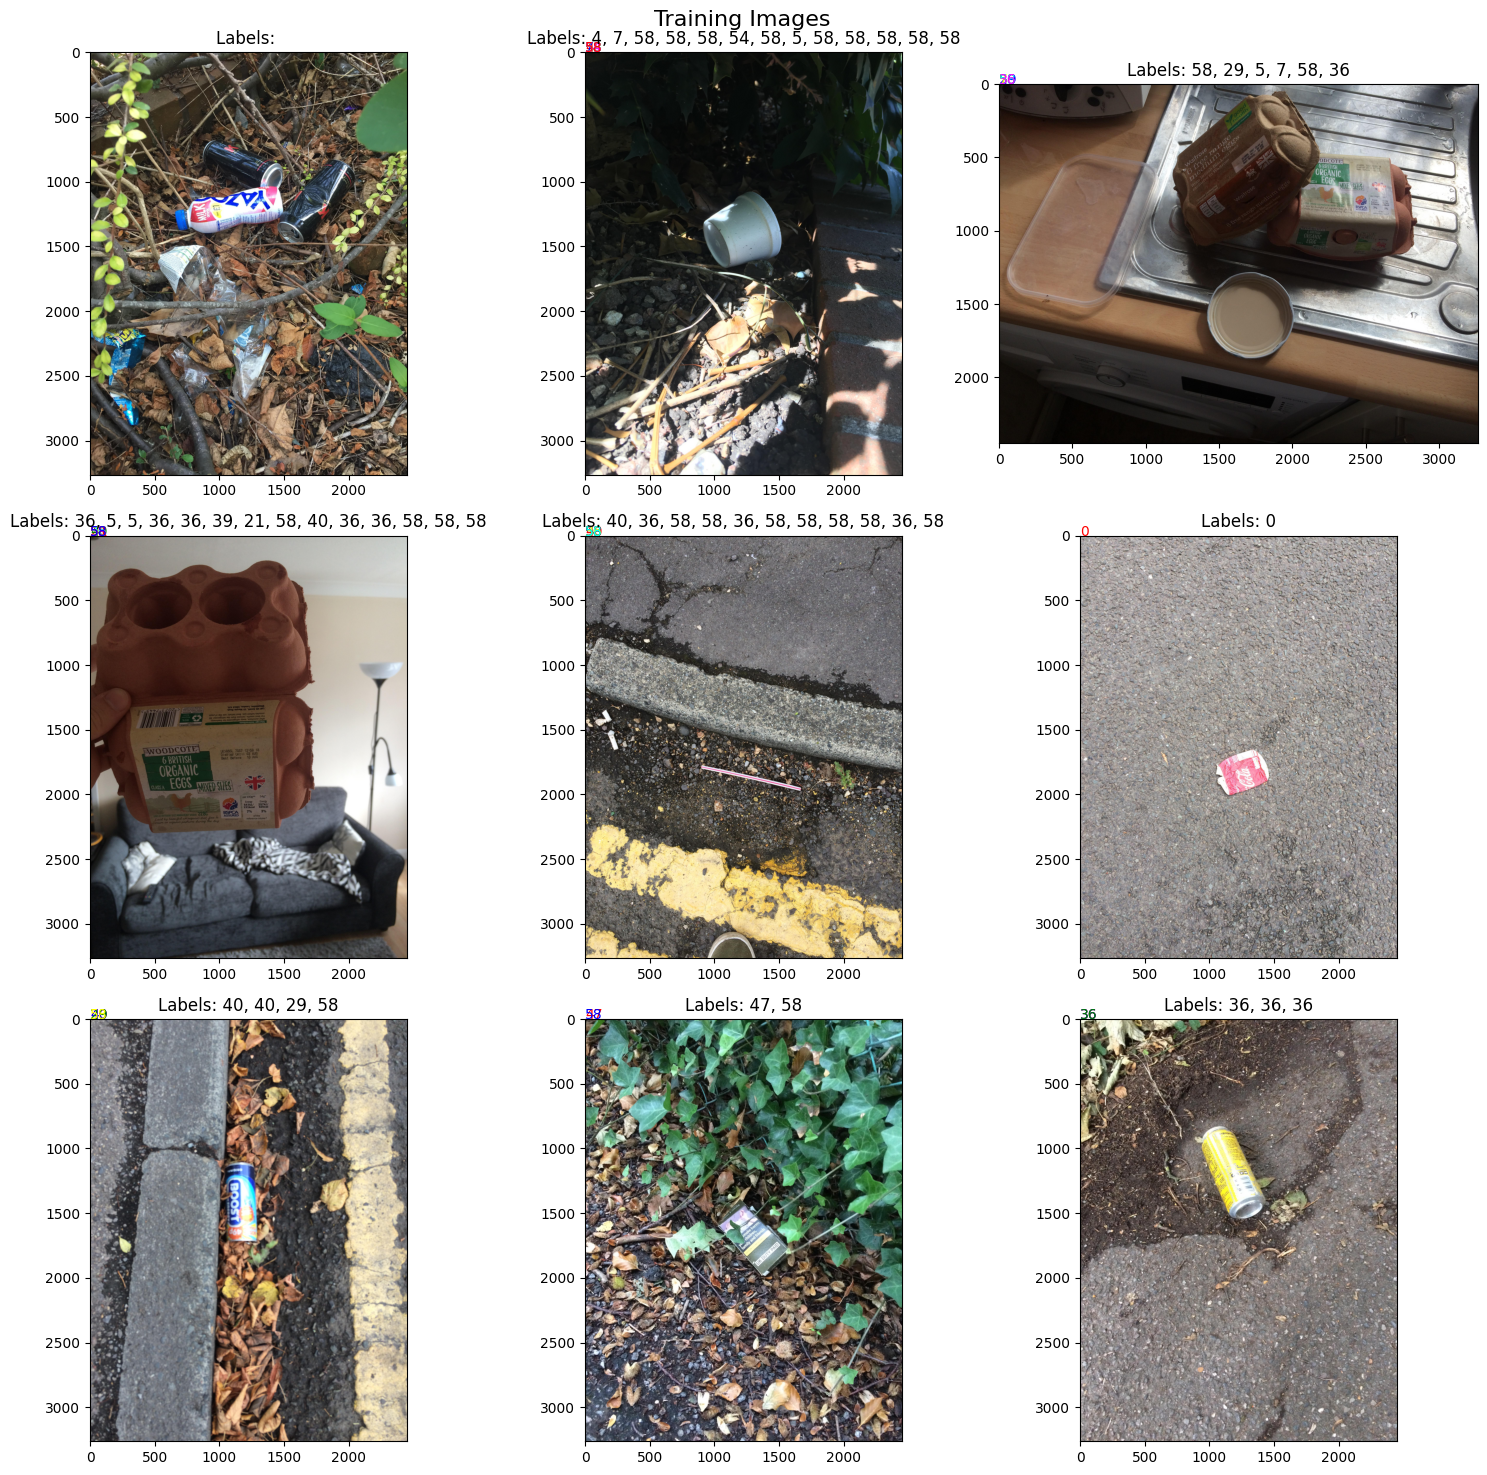

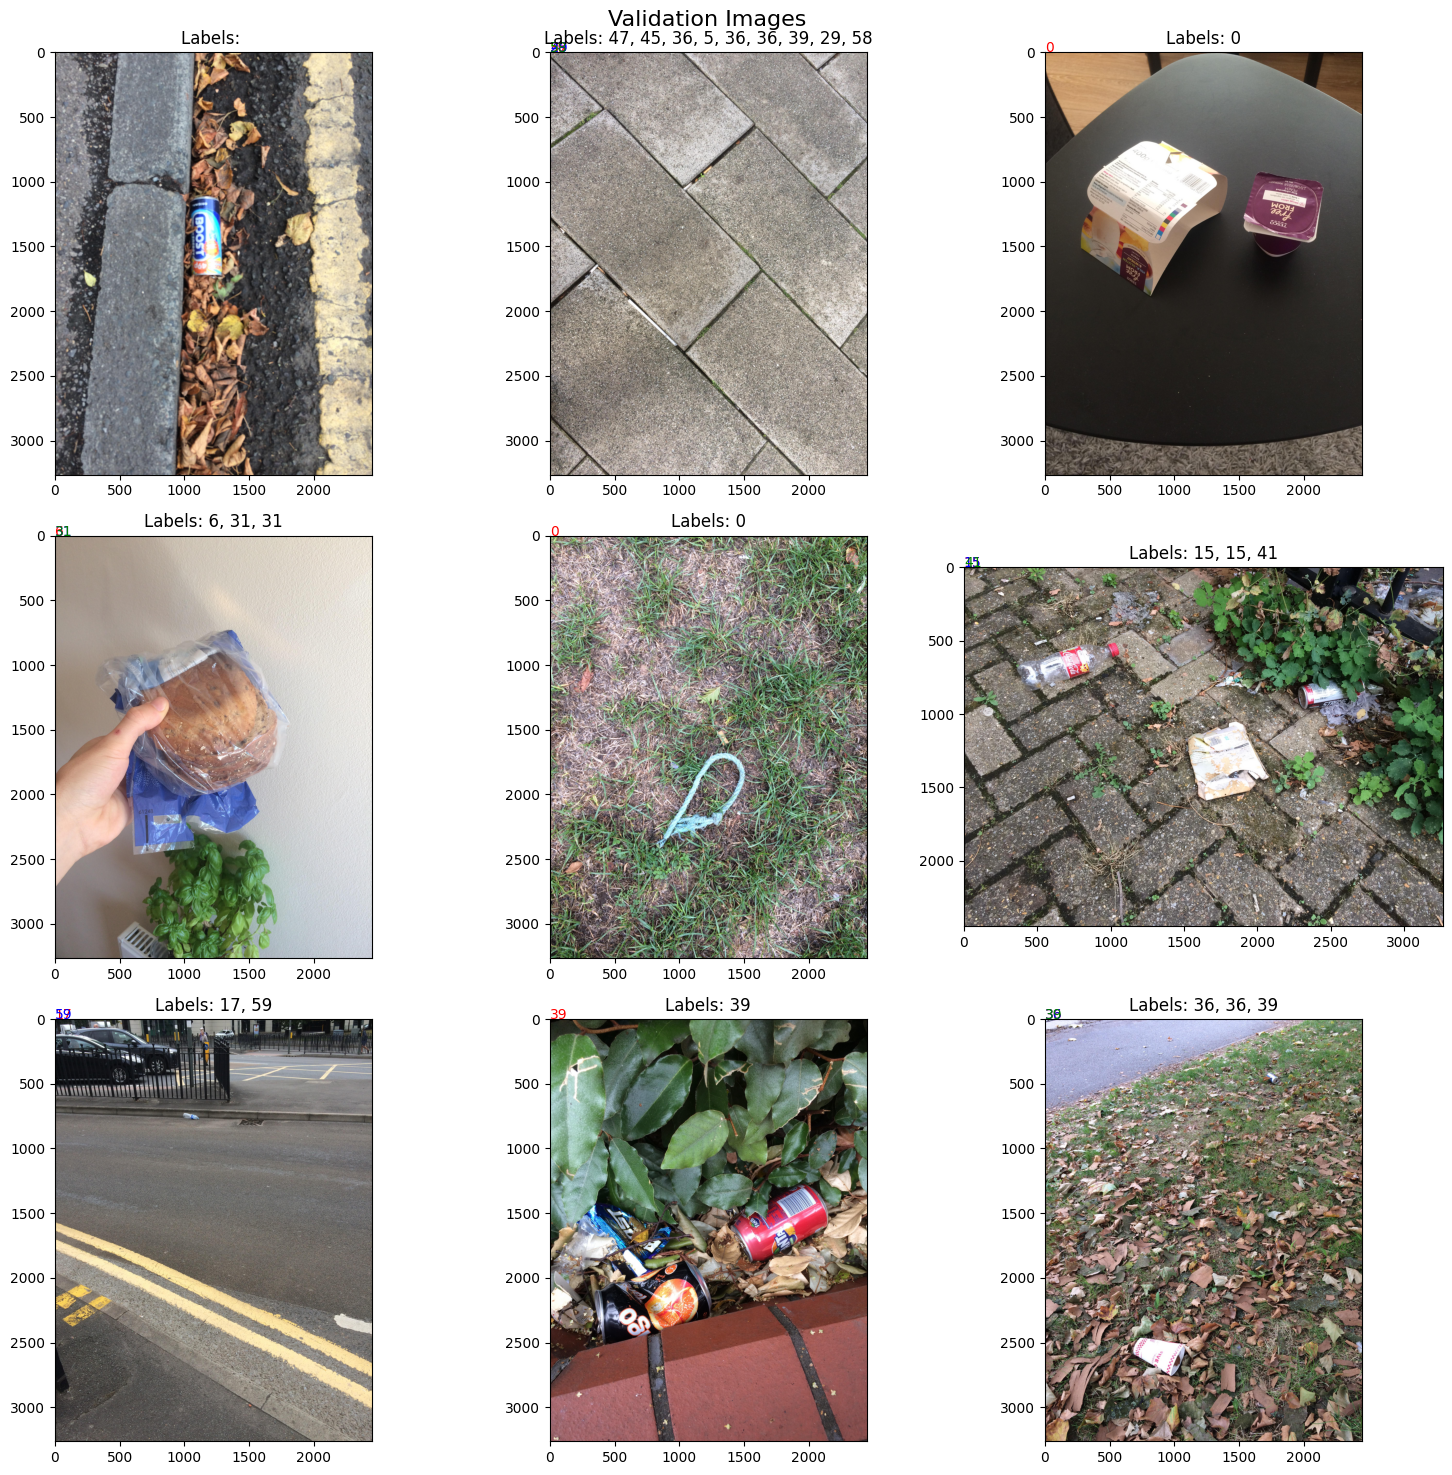

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import cv2

def plot_images_in_grid(image_paths, label_paths, n, m, title=""):
    fig, axarr = plt.subplots(n, m, figsize=(15, 15))

    # If a main title is provided, set it for the entire grid
    if title:
        fig.suptitle(title, fontsize=16)

    for i in range(n):
        for j in range(m):
            image_path = image_paths[i * m + j]
            label_path = label_paths[i * m + j]

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, c = image.shape
            boxes, labels = parse_label(label_path, h, w)

            draw_image_with_boxes(axarr[i, j], image, boxes, labels)

            # Set the title for each subplot as the image's labels
            axarr[i, j].set_title("Labels: " + ", ".join(map(str, labels)))

    plt.tight_layout()
    plt.show()


def get_image_label_paths(folder):
    image_paths = sorted(glob.glob(os.path.join(folder, "images", "*.JPG")))
    label_paths = sorted(glob.glob(os.path.join(folder, "labels", "*.txt")))
    return image_paths, label_paths

def parse_label(label_path, width, height):
    with open(label_path, "r") as file:
        lines = file.readlines()

    boxes = []
    labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        # Convert from normalized coordinates to actual coordinates
        x1 = (x_center - width) * width  # assuming images are 1024x1024
        y1 = (y_center - height) * height
        x2 = (x_center + width ) * width
        y2 = (y_center + height ) * height
        boxes.append([x1, y1, x2, y2])
        labels.append(class_id)

    return boxes, labels


def draw_image_with_boxes(ax, image, boxes, labels=None, color_list=None):
    """Draws an image with bounding boxes."""
    ax.imshow(image)

    # If no specific colors provided, use a default list
    if color_list is None:
        color_list = ["red", "blue", "green", "yellow", "cyan", "magenta"] * 10

    for idx, box in enumerate(boxes):
        # Extract box coordinates
        x, y, w, h = box

        # Choose color
        color = color_list[idx % len(color_list)]

        # Draw the bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # If labels provided, annotate the box with the label
        if labels:
            ax.text(x, y, str(labels[idx]), color=color)

# For training images
n = 3 # no of rows
m = 3 # no of columns
train_folder = "./taco/train"
train_image_paths, train_label_paths = get_image_label_paths(train_folder)
plot_images_in_grid(train_image_paths, train_label_paths, n, m, title="Training Images")

# For test images
val_folder = "./taco/val"
val_image_paths, val_label_paths = get_image_label_paths(val_folder)
plot_images_in_grid(val_image_paths, val_label_paths, n, m, title="Validation Images")

In [20]:
from pycocotools.coco import COCO

# Load COCO annotations
data_source = COCO(annotation_file='data/annotations.json')

# Extract class names from COCO annotations
categories = data_source.loadCats(data_source.getCatIds())
class_names = [category['name'] for category in categories]

# Extract number of classes
num_classes = len(class_names)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [21]:
num_classes

60

In [22]:
%%writefile taco.yaml

# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: /content/drive/MyDrive/AI/Recycling/taco/train/images/
val: /content/drive/MyDrive/AI/Recycling/taco/val/images/
test: /content/drive/MyDrive/AI/Recycling/taco/test/images/

# number of classes
nc: 60

# class names
names: ['Aluminium foil',
 'Battery',
 'Aluminium blister pack',
 'Carded blister pack',
 'Other plastic bottle',
 'Clear plastic bottle',
 'Glass bottle',
 'Plastic bottle cap',
 'Metal bottle cap',
 'Broken glass',
 'Food Can',
 'Aerosol',
 'Drink can',
 'Toilet tube',
 'Other carton',
 'Egg carton',
 'Drink carton',
 'Corrugated carton',
 'Meal carton',
 'Pizza box',
 'Paper cup',
 'Disposable plastic cup',
 'Foam cup',
 'Glass cup',
 'Other plastic cup',
 'Food waste',
 'Glass jar',
 'Plastic lid',
 'Metal lid',
 'Other plastic',
 'Magazine paper',
 'Tissues',
 'Wrapping paper',
 'Normal paper',
 'Paper bag',
 'Plastified paper bag',
 'Plastic film',
 'Six pack rings',
 'Garbage bag',
 'Other plastic wrapper',
 'Single-use carrier bag',
 'Polypropylene bag',
 'Crisp packet',
 'Spread tub',
 'Tupperware',
 'Disposable food container',
 'Foam food container',
 'Other plastic container',
 'Plastic glooves',
 'Plastic utensils',
 'Pop tab',
 'Rope & strings',
 'Scrap metal',
 'Shoe',
 'Squeezable tube',
 'Plastic straw',
 'Paper straw',
 'Styrofoam piece',
 'Unlabeled litter',
 'Cigarette']

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)

Overwriting taco.yaml


### Train smaller model

In [23]:
!pip install -qq ultralytics

In [24]:
!yolo train data=taco.yaml model=yolov8n.pt epochs=15 lr0=0.01

Ultralytics YOLOv8.0.189 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=taco.yaml, epochs=15, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=F

### Run Predictions on Val dataset

In [27]:
!ls runs/detect/train5/weights/best.pt

runs/detect/train5/weights/best.pt


In [28]:
!yolo val model=runs/detect/train5/weights/best.pt data=taco.yaml split=test

Ultralytics YOLOv8.0.189 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3017348 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/AI/Recycling/taco/test/labels... 182 images, 0 backgrounds, 0 corrupt: 100% 182/182 [00:07<00:00, 23.62it/s]
val: New cache created: /content/drive/MyDrive/AI/Recycling/taco/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 12/12 [00:23<00:00,  1.93s/it]
                   all        182        512      0.348      0.162      0.119      0.105
        Aluminium foil        182         27      0.265      0.259      0.178      0.148
               Battery        182         19      0.117     0.0185      0.114     0.0909
  Other plastic bottle        182          6      0.618        0.5      0.489      0.464
  Clear plastic bottle        182         33      0.261      0.636      0.279      0.218
          Glass bottle        182          7 

### Run Predictions on Test dataset

In [29]:
# For test images
test_folder = "./taco/test"
test_image_paths, test_label_paths = get_image_label_paths(test_folder)
plot_images_in_grid(test_image_paths, test_label_paths, n, m, title="Test Images")

Output hidden; open in https://colab.research.google.com to view.

### Train bigger model